<a href="https://colab.research.google.com/github/AaronMeoded/NLP_Spring24/blob/main/AaronMeoded_assignment_4_part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part III
Using the previous two tutorials, please answer the following using an encorder-decoder approach and an LSTM compared approach.

Please create a transformer-based classifier for English name classification into male or female.

There are several datasets for name for male or female classification. In subseuqent iterations, this could be expanded to included more classifications.

Below is the source from NLTK, which only has male and female available but could be used for the purposes of this assignment.

```
names = nltk.corpus.names
names.fileids()
['female.txt', 'male.txt']
male_names = names.words('male.txt')
female_names = names.words('female.txt')
[w for w in male_names if w in female_names]
['Abbey', 'Abbie', 'Abby', 'Addie', 'Adrian', 'Adrien', 'Ajay', 'Alex', 'Alexis',
'Alfie', 'Ali', 'Alix', 'Allie', 'Allyn', 'Andie', 'Andrea', 'Andy', 'Angel',
'Angie', 'Ariel', 'Ashley', 'Aubrey', 'Augustine', 'Austin', 'Averil', ...]
```

In [ ]:
### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

## Transformer Approach, Encoder-decoder Approach, and LSTM Approach

### Transformer Approach:

1. Data Preparation

In [ ]:
import nltk
from nltk.corpus import names
import random
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load names
nltk.download('names')
male_names = names.words('male.txt')
female_names = names.words('female.txt')

# Create labels
male_labels = [0] * len(male_names)  # 0 for male
female_labels = [1] * len(female_names)  # 1 for female

# Combine data
all_names = male_names + female_names
labels = male_labels + female_labels

# Shuffle data
combined = list(zip(all_names, labels))
random.shuffle(combined)
all_names, labels = zip(*combined)

# Split data
train_names, test_names, train_labels, test_labels = train_test_split(all_names, labels, test_size=0.2)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def encode_names(names):
    return tokenizer(names, padding=True, truncation=True, max_length=10, return_tensors="tf")

train_encodings = encode_names(train_names)
test_encodings = encode_names(test_names)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

2. Model Setup

In [ ]:
# Load pre-trained BERT model with a classification head
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define the optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3. Training

In [ ]:
# Convert labels to tensorflow format
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Train the model
model.fit(train_encodings.data, train_labels, epochs=3, batch_size=8, validation_data=(test_encodings.data, test_labels))

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
795/795 [==============================] - 163s 101ms/step - loss: 0.3925 - accuracy: 0.8326 - val_loss: 0.3475 - val_accuracy: 0.8615
Epoch 2/3
795/795 [==============================] - 63s 79ms/step - loss: 0.2676 - accuracy: 0.8892 - val_loss: 0.3267 - val_accuracy: 0.8653
Epoch 3/3
795/795 [==============================] - 63s 79ms/step - loss: 0.1866 - accuracy: 0.9223 - val_loss: 0.4348 - val_accuracy: 0.8634


4. Evaluation

In [ ]:
# Evaluate the model
model.evaluate(test_encodings.data, test_labels)

50/50 [==============================] - 2s 33ms/step - loss: 0.4348 - accuracy: 0.8634


[0.43480196595191956, 0.8634361028671265]

50/50 [==============================] - 36s 95ms/step
              precision    recall  f1-score   support

        Male       0.82      0.81      0.81       583
      Female       0.89      0.90      0.89      1006

    accuracy                           0.86      1589
   macro avg       0.85      0.85      0.85      1589
weighted avg       0.86      0.86      0.86      1589



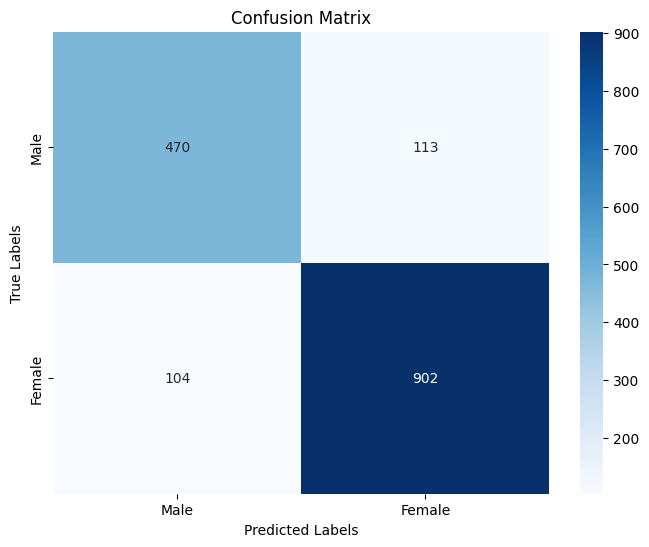

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting the test dataset
predictions = model.predict(test_encodings.data)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Generating the classification report which includes precision, recall, and F1-score
print(classification_report(test_labels, predicted_labels, target_names=['Male', 'Female']))

# Computing the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Encoder-decoder Model and LSTM model:

In [1]:
import numpy as np
import tensorflow as tf
from nltk.corpus import names
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
nltk.download('names')

# Load names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

# Labels: 0 for male, 1 for female
data = [(name, 0) for name in male_names] + [(name, 1) for name in female_names]
names, labels = zip(*data)

# Tokenization and padding
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names)
sequences = tokenizer.texts_to_sequences(names)
max_len = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = to_categorical(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


In [2]:
def build_lstm_model(input_dim, output_dim, input_length):
    model = tf.keras.Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        LSTM(64),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Constants for the model
input_dim = len(tokenizer.word_index) + 1
output_dim = 50  # Embedding size
input_length = max_len

# Build and train the LSTM model
lstm_model = build_lstm_model(input_dim, output_dim, input_length)
lstm_model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
179/179 [==============================] - 9s 22ms/step - loss: 0.6144 - accuracy: 0.6716 - val_loss: 0.5354 - val_accuracy: 0.7358
Epoch 2/10
179/179 [==============================] - 2s 11ms/step - loss: 0.5153 - accuracy: 0.7543 - val_loss: 0.4931 - val_accuracy: 0.7799
Epoch 3/10
179/179 [==============================] - 1s 8ms/step - loss: 0.4907 - accuracy: 0.7695 - val_loss: 0.4733 - val_accuracy: 0.7909
Epoch 4/10
179/179 [==============================] - 1s 8ms/step - loss: 0.4810 - accuracy: 0.7744 - val_loss: 0.4793 - val_accuracy: 0.7909
Epoch 5/10
179/179 [==============================] - 2s 9ms/step - loss: 0.4747 - accuracy: 0.7783 - val_loss: 0.4647 - val_accuracy: 0.7830
Epoch 6/10
179/179 [==============================] - 2s 12ms/step - loss: 0.4616 - accuracy: 0.7879 - val_loss: 0.4389 - val_accuracy: 0.7940
Epoch 7/10
179/179 [==============================] - 2s 11ms/step - loss: 0.4530 - accuracy: 0.7882 - val_loss: 0.4146 - val_accuracy: 0.8176
Ep

In [4]:
def build_encoder_decoder_model(input_dim, output_dim, input_length):
    # Encoder
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(input_dim=input_dim, output_dim=output_dim)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(64, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(1,))
    decoder_embedding = Embedding(input_dim=input_dim, output_dim=output_dim)(decoder_inputs)
    decoder_lstm = LSTM(64, return_sequences=False, return_state=True)  # Changed return_sequences to False
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(2, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
enc_dec_model = build_encoder_decoder_model(input_dim, output_dim, input_length)

# Train the model
decoder_input_data = np.zeros((len(X_train), 1))  # Dummy input for the decoder
enc_dec_model.fit([X_train, decoder_input_data], y_train, epochs=10, validation_split=0.1)

Epoch 1/10
179/179 [==============================] - 9s 20ms/step - loss: 0.5963 - accuracy: 0.6812 - val_loss: 0.5147 - val_accuracy: 0.7453
Epoch 2/10
179/179 [==============================] - 1s 8ms/step - loss: 0.5080 - accuracy: 0.7582 - val_loss: 0.4953 - val_accuracy: 0.7610
Epoch 3/10
179/179 [==============================] - 2s 10ms/step - loss: 0.4929 - accuracy: 0.7629 - val_loss: 0.4940 - val_accuracy: 0.7736
Epoch 4/10
179/179 [==============================] - 1s 6ms/step - loss: 0.4777 - accuracy: 0.7762 - val_loss: 0.4594 - val_accuracy: 0.7925
Epoch 5/10
179/179 [==============================] - 1s 6ms/step - loss: 0.4660 - accuracy: 0.7799 - val_loss: 0.4476 - val_accuracy: 0.7925
Epoch 6/10
179/179 [==============================] - 1s 6ms/step - loss: 0.4582 - accuracy: 0.7841 - val_loss: 0.4278 - val_accuracy: 0.7862
Epoch 7/10
179/179 [==============================] - 1s 6ms/step - loss: 0.4481 - accuracy: 0.7893 - val_loss: 0.4134 - val_accuracy: 0.8113
Epoc

Evaluating LSTM Model:
50/50 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

        Male       0.81      0.61      0.70       621
      Female       0.79      0.91      0.84       968

    accuracy                           0.79      1589
   macro avg       0.80      0.76      0.77      1589
weighted avg       0.80      0.79      0.79      1589



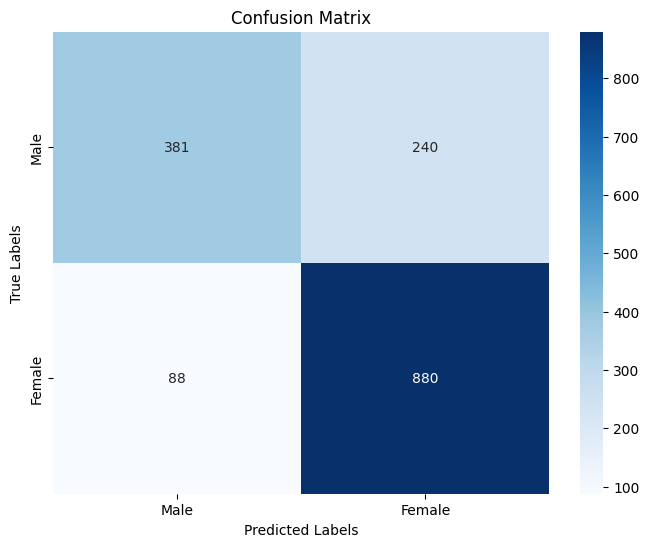

Evaluating Encoder-Decoder LSTM Model:
50/50 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

        Male       0.70      0.80      0.75       621
      Female       0.86      0.78      0.82       968

    accuracy                           0.79      1589
   macro avg       0.78      0.79      0.78      1589
weighted avg       0.80      0.79      0.79      1589



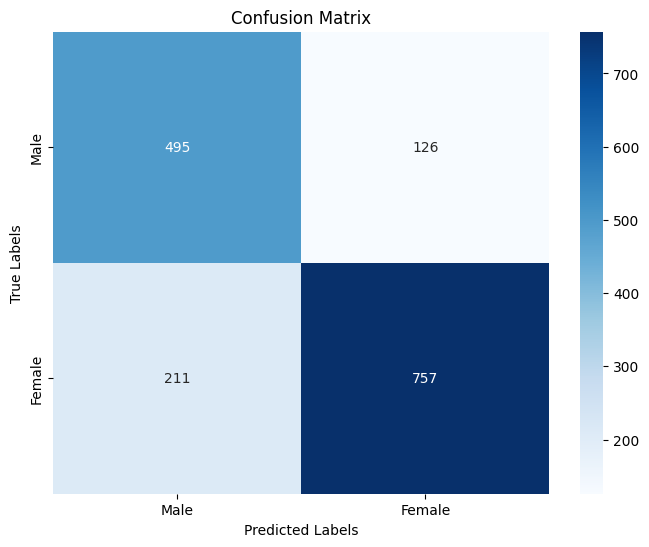

array([[495, 126],
       [211, 757]])

In [5]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, decoder_input_test=None):
    # Predict the output
    if decoder_input_test is not None:
        y_pred = model.predict([X_test, decoder_input_test])
    else:
        y_pred = model.predict(X_test)

    # Convert probabilities to labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Print classification report
    print(classification_report(y_true_labels, y_pred_labels, target_names=['Male', 'Female']))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Return the raw scores
    return cm

print("Evaluating LSTM Model:")
evaluate_model(lstm_model, X_test, y_test)
decoder_input_test = np.zeros((len(X_test), 1))  # Dummy input for the decoder

print("Evaluating Encoder-Decoder LSTM Model:")
evaluate_model(enc_dec_model, X_test, y_test, decoder_input_test=decoder_input_test)


In [ ]:
### END CODE HERE ###

# References
1. https://arxiv.org/pdf/2102.03692.pdf
2. https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/exercise/13-attention.html
3. https://towardsdatascience.com/deep-learning-gender-from-name-lstm-recurrent-neural-networks-448d64553044
4. https://www.nltk.org/book/ch02.html#sec-lexical-resources